In [ ]:
"""The file needed to run this notebook can be accessed from the following folder using a UTS email account:
https://drive.google.com/drive/folders/1y6e1Z2SbLDKkmvK3-tyQ6INO5rrzT3jp
"""

##Task-1: Installation of Google Object Detection API and required packages




### Step 1: Import packages






In [ ]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 1.x 
!pip install numpy==1.17.4

TensorFlow 1.x selected.
     |████████████████████████████████| 20.0MB 33.5MB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [ ]:
import os
import re
import tensorflow as tf

In [ ]:
print(tf.__version__)

1.15.2


In [ ]:
pip install --upgrade tf_slim

     |████████████████████████████████| 358kB 2.8MB/s 


### Step 2: Initial Configuration to Select SSD model config file and selection of other hyperparameters

In [ ]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/Tony607/object_detection_demo'

# Number of training steps.
num_steps = 10000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'facessd_mobilenet_v2_quantized_open_image_v4': {
        'model_name': 'facessd_mobilenet_v2_quantized_320x320_open_image_v4',
        'pipeline_file': 'facessd_mobilenet_v2_quantized_320x320_open_image_v4.config',
        'batch_size': 32
    }
}

# Pick the model you want to use

selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [ ]:
%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'object_detection_demo'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 11.16 MiB | 6.28 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/object_detection_demo
Already up to date.


### Step 3: Download Google Object Detection API and other dependencies

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

##Task-2: Conversion of XML annotations and images into tfrecords for training and testing datasets

### Step 4: Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.
```bash
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt
```

In [ ]:
import zipfile
#Extract the zip file 
local_zip = '/content/drive/My Drive/Assignment 3/resized-20200512T050739Z-001.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/object_detection_demo/data/images/train')
zip_ref.close()


In [ ]:
import zipfile
#Extract the zip file 
local_zip = '/content/drive/My Drive/Assignment 3/resized-20200512T050739Z-001.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/object_detection_demo/data/images/test')
zip_ref.close()

In [ ]:
#create the annotation directory
%cd /content/object_detection_demo/data
annotation_dir = 'annotations/'
os.makedirs(annotation_dir, exist_ok=True)


/content/object_detection_demo/data


In [ ]:
"""Need to manually upload  the label_pbtxt file and the train_labels.csv and test_labels.csv
into the annotation folder using the link here
https://drive.google.com/drive/folders/1NqKz2tC8I5eL5Qo4YzZiEph8W-dtI44d
"""

In [ ]:
%cd {repo_dir_path}
# Generate `train.record`
#Only need to change the path for csv input
!python generate_tfrecord.py --csv_input=/content/object_detection_demo/data/annotations/train_labels.csv --output_path=/content/object_detection_demo/data/annotations/train.record --img_path=/content/object_detection_demo/data/images/train/resized --label_map /content/object_detection_demo/data/annotations/label_map.pbtxt

/content/object_detection_demo


W0617 08:50:25.861793 140277859268480 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0617 08:50:27.694240 140277859268480 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/data/annotations/train.record


In [ ]:
# Generate `test.record`
#Only need to change the path for csv input
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=/content/object_detection_demo/data/images/test/resized --label_map data/annotations/label_map.pbtxt



W0617 08:40:17.209351 139957186725760 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0617 08:40:18.559039 139957186725760 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/data/annotations/test.record


In [ ]:
test_record_fname = '/content/object_detection_demo/data/annotations/test.record'
train_record_fname = '/content/object_detection_demo/data/annotations/train.record'
label_map_pbtxt_fname = '/content/object_detection_demo/data/annotations/label_map.pbtxt'

### Step 5. Download the base model for transfer learning

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 63 root   root 4.0K Jun 17 08:50 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

##Task-3: Training: Transfer learning from already trained models



###Step 6: configuring a training pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #set image resizer
    """s = re.sub('initial_learning_rate: [-+]?[0-9]*\.?[0-9]+',
               'initial_learning_rate: {}'.format(initial_learning_rate), s)"""

    
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

### Step 7. Install Tensorboard to visualize the progress of training process

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-06-17 08:51:40--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.86.203.217, 50.16.94.112, 54.208.57.0, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.86.203.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.08MB/s    in 2.2s    

2020-06-17 08:51:43 (6.08 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')


### Step: 8 Get tensorboard link

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://e5f1ada81844.ngrok.io


### Step 9.  Training the model

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0617 08:52:21.150880 139802647791488 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0617 08:52:21.151218 139802647791488 config_util.py:523] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0617 08:52:21.151412 139802647791488 config_util.py:523] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0617 08:52:21.151632 139802647791488 config_util.py:523] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0617 08:52:21.151835 139802647791488 config_util.py:523] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0617 08:52:21.152001 139802647791488 config_util.py:523] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0617 08:52:21.152132 139802647791488 config_util.py

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1592284871.2e559208a432
export
graph.pbtxt
model.ckpt-10000.data-00000-of-00001
model.ckpt-10000.index
model.ckpt-10000.meta
model.ckpt-5510.data-00000-of-00001
model.ckpt-5510.index
model.ckpt-5510.meta
model.ckpt-6633.data-00000-of-00001
model.ckpt-6633.index
model.ckpt-6633.meta
model.ckpt-7759.data-00000-of-00001
model.ckpt-7759.index
model.ckpt-7759.meta
model.ckpt-8880.data-00000-of-00001
model.ckpt-8880.index
model.ckpt-8880.meta


##Task-4:  Freezing a trained model and export it for inference


### Step: 10 Exporting a Trained Inference Graph

In [ ]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-10000
Instructions for updating:
Please use `layer.__call__` method instead.
W0616 06:46:28.778084 140645638100864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0616 06:46:31.542984 140645638100864 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0616 06:46:31.590529 140645638100864 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0616 06:46:31.740777 140645638100864 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:dep

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


### Step 11: Use frozen model for inference.

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M Jun 15 21:52 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/object_detection_demo/test/resized_C99P60ThinF_IMG_20150918_141857_cell_26.png', '/content/object_detection_demo/test/resized_C133P94ThinF_IMG_20151004_155144_cell_119.png']


/content/models/research/object_detection


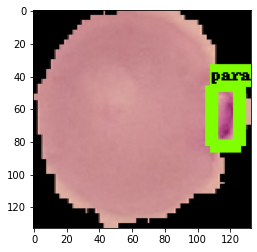

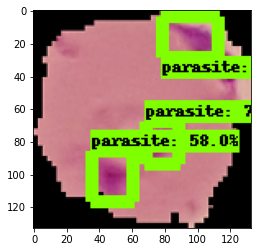

In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (4, 4)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)